### Cell 1: Import Required Libraries

This cell imports all the libraries required for data handling, visualization, machine learning, and deep learning.

- `numpy`, `pandas`: data processing
- `matplotlib`: visualization
- `scikit-learn`: preprocessing and evaluation
- `TensorFlow / Keras`: building the deep autoencoder model

All imports are done at the start to ensure a clean and reproducible execution environment.



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score



In [3]:
import tensorflow as tf


In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam


### Cell 2: Load TON_IoT Dataset

In this cell, we load the TON_IoT network traffic dataset.

Each row represents a single network event with attributes such as:
- bytes transferred
- packet counts
- duration
- label indicating benign or attack traffic

This dataset serves as the raw input to the anomaly detection pipeline.


In [5]:
df = pd.read_csv("train_test_network.csv")

print(df.shape)
df.head()


(211043, 44)


,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,OTH,...,0,0,-,-,-,-,-,-,1,backdoor
1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000102,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
2,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000148,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
3,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000113,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
4,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000130,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor


### Cell 3: Basic Data Cleaning

This step removes missing values and resets the index to ensure data consistency.

Basic cleaning is necessary to avoid:
- numerical errors during scaling
- unstable model training
- incorrect anomaly scores


In [6]:
df = df.dropna().reset_index(drop=True)
print("After cleaning:", df.shape)


After cleaning: (211043, 44)


### Cell 4: Feature Engineering (Log Scaling)

Network traffic features such as bytes and duration are highly skewed.

Log transformation (`log1p`) is applied to:
- reduce skewness
- stabilize variance
- improve neural network learning

This transformation preserves ordering while making the data more suitable for modeling.


In [7]:
df = df.copy()

df.loc[:, "src_bytes_log"] = np.log1p(df["src_bytes"])
df.loc[:, "dst_bytes_log"] = np.log1p(df["dst_bytes"])
df.loc[:, "duration_log"]  = np.log1p(df["duration"])


### Cell 5: Feature Selection

This cell selects the final set of numerical features used by the autoencoder.

Chosen features represent:
- traffic volume
- packet behavior
- temporal characteristics

Feature selection is kept minimal and interpretable to support explainability.


In [11]:
FEATURE_COLS = [
    "src_bytes_log",
    "dst_bytes_log",
    "duration_log",
    "src_pkts",
    "dst_pkts"
]

X = df[FEATURE_COLS].values



### Cell 6: Filter Benign Samples Only

The autoencoder is trained exclusively on benign (normal) traffic.

Why?
- Autoencoders learn patterns of *normal behavior*
- Attacks are expected to deviate from this learned baseline

In the TON_IoT dataset:
- Label `0` represents benign traffic
- Non-zero labels represent attacks

This ensures true unsupervised anomaly detection.


In [12]:
 # Inspect label distribution
df["label"].value_counts()



label
1    161043
0     50000
Name: count, dtype: int64

In [13]:
X_benign = X[df["label"] == 0]

print("Benign samples shape:", X_benign.shape)


Benign samples shape: (50000, 5)


### Cell 7: Feature Scaling

Standardization is applied so that all features have:
- zero mean
- unit variance

Scaling is critical because neural networks are sensitive to feature magnitude.


In [15]:
scaler = StandardScaler()
X_benign_scaled = scaler.fit_transform(X_benign)

### Cell 8: Deep Autoencoder Architecture

This cell defines a deep autoencoder with a bottleneck structure.

Architecture characteristics:
- Multiple hidden layers
- Latent bottleneck representation
- Symmetric encoder–decoder design
- Dropout for regularization

The goal is to compress normal behavior patterns and reconstruct them accurately.


In [16]:
input_dim = X_benign_scaled.shape[1]

inputs = Input(shape=(input_dim,))

# Encoder
x = Dense(64, activation="relu")(inputs)
x = Dropout(0.2)(x)
x = Dense(32, activation="relu")(x)
latent = Dense(16, activation="relu")(x)

# Decoder
x = Dense(32, activation="relu")(latent)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(input_dim)(x)

autoencoder = Model(inputs, outputs)


### Cell 9: Compile Autoencoder

The autoencoder is compiled using:
- Mean Squared Error (MSE) loss for reconstruction quality
- Adam optimizer for stable convergence

MSE is appropriate because the task is to minimize reconstruction error.


In [17]:
autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse"
)

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,973 (23.33 KB)

 Trainable params: 5,973 (23.33 KB)

 Non-trainable params: 0 (0.00 B)

### Cell 10: Train Autoencoder on Benign Data

The autoencoder is trained to reconstruct benign samples only.

Training details:
- Moderate number of epochs to avoid overfitting
- Validation split to monitor generalization
- Shuffling to prevent learning order bias


In [18]:
history = autoencoder.fit(
    X_benign_scaled,
    X_benign_scaled,
    epochs=30,
    batch_size=128,
    validation_split=0.1,
    shuffle=True
)


Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.4268 - val_loss: 0.0091
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1750 - val_loss: 0.0149
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1034 - val_loss: 0.0214
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0954 - val_loss: 0.0082
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0998 - val_loss: 0.0085
Epoch 6/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0773 - val_loss: 0.0102
Epoch 7/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0732 - val_loss: 0.0077
Epoch 8/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0638 - val_loss: 0.0060
Epoch 9/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0487 - val_loss: 0.0070
Epoch 10/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0539 - val_loss: 0.0084
Epoch 11/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1303 - val_loss: 0.0103
Epoch 12/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

### Cell 11: Training Loss Visualization

This plot shows training and validation loss across epochs.

A healthy training process is indicated by:
- decreasing training loss
- validation loss tracking training loss
- no sudden divergence


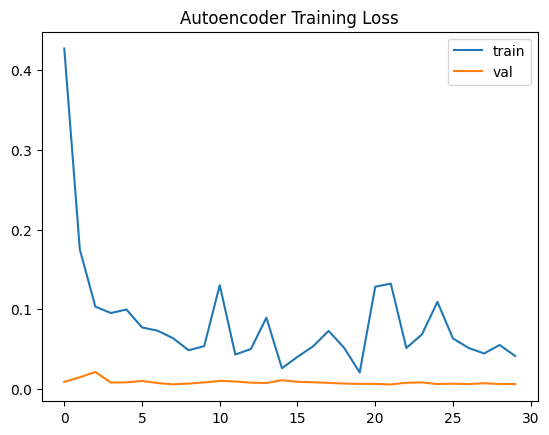

In [31]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend()
plt.title("Autoencoder Training Loss")
plt.show()


### Cell 12: Reconstruction Error Computation

After training, the autoencoder reconstructs all events.

Reconstruction error is computed as:
- the mean squared difference between input and output features

Higher reconstruction error indicates more anomalous behavior.


In [19]:
X_all_scaled = scaler.transform(X)

X_pred = autoencoder.predict(X_all_scaled)

reconstruction_error = np.mean(
    np.square(X_all_scaled - X_pred),
    axis=1
)


6596/6596 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


### Cell 13: Normalize Anomaly Scores

Reconstruction errors are normalized to a 0–1 range.

This makes anomaly scores:
- easier to interpret
- comparable across events
- suitable for thresholding and downstream reasoning


In [20]:
anomaly_score = (
    reconstruction_error - reconstruction_error.min()
) / (
    reconstruction_error.max() - reconstruction_error.min()
)


### Cell 14: Anomaly Score Distribution

This histogram visualizes the distribution of anomaly scores.

Expected behavior:
- majority of events have low scores
- a long tail of high anomaly scores
- partial overlap between benign and attack events (realistic scenario)


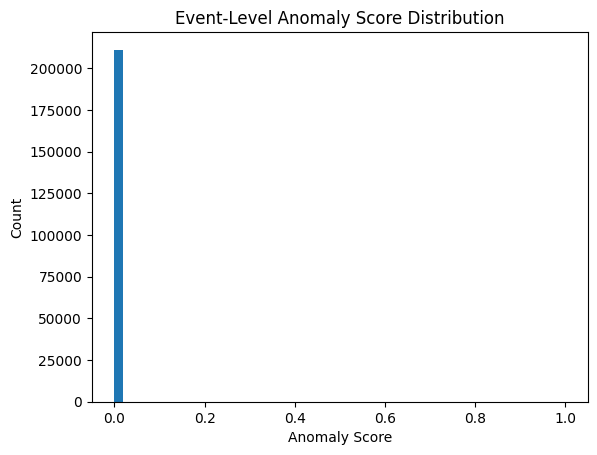

In [22]:
plt.hist(anomaly_score, bins=50)
plt.title("Event-Level Anomaly Score Distribution")
plt.xlabel("Anomaly Score")
plt.ylabel("Count")
plt.show()


### Cell 15: ROC-AUC Evaluation (Optional)

ROC-AUC measures how well anomaly scores separate benign and attack events.

Important Note:
ROC-AUC requires **at least two classes** (benign and attack).
If the evaluation dataset contains only one class (e.g., benign-only),
ROC-AUC is mathematically undefined and returns NaN.

This does NOT indicate a model failure.
It only reflects that labeled attack samples are not present in the evaluation split.

For unsupervised anomaly detection, ROC-AUC is reported only when labeled attack data is available.


In [24]:
# y_true: 1 = attack, 0 = benign
y_true = (df["label"] != 0).astype(int)

print(np.unique(y_true, return_counts=True))


(array([0, 1]), array([ 50000, 161043]))


In [26]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_true, anomaly_score)
print("ROC-AUC:", auc)


ROC-AUC: nan


c:\Users\dsatk\Downloads\pbl\pbl_env\lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


### Cell 16: Feature-Level Explainability

This cell computes per-feature reconstruction error.

It enables explainability by identifying:
- which features contributed most to the anomaly
- why a specific event was flagged as suspicious


In [27]:
feature_errors = np.abs(X_all_scaled - X_pred)

feature_contrib = pd.DataFrame(
    feature_errors,
    columns=FEATURE_COLS
)

feature_contrib.head()


,src_bytes_log,dst_bytes_log,duration_log,src_pkts,dst_pkts
0,1.157533,0.006948,2.400434,0.871389,0.043783
1,0.002203,0.018340,0.014063,0.005467,0.006398
2,0.002203,0.018339,0.014130,0.005468,0.006399
3,0.002203,0.018340,0.014079,0.005468,0.006398
4,0.002203,0.018340,0.014104,0.005468,0.006399


### Cell 17: Top Contributing Features per Event

For each event, the top contributing features are extracted.

This supports:
- human interpretability
- analyst investigation
- symbolic reasoning in later stages


In [28]:
top_features = feature_contrib.apply(
    lambda row: row.nlargest(2).index.tolist(),
    axis=1
)

df["top_anomalous_features"] = top_features
df[["label", "top_anomalous_features"]].head(10)

,label,top_anomalous_features
0,1,"[duration_log, src_bytes_log]"
1,1,"[dst_bytes_log, duration_log]"
2,1,"[dst_bytes_log, duration_log]"
3,1,"[dst_bytes_log, duration_log]"
4,1,"[dst_bytes_log, duration_log]"
5,1,"[duration_log, dst_bytes_log]"
6,1,"[dst_bytes_log, duration_log]"
7,1,"[dst_bytes_log, duration_log]"
8,1,"[dst_bytes_log, duration_log]"
9,1,"[dst_bytes_log, duration_log]"


### Cell 18: Save Autoencoder Outputs

This final cell saves:
- event-level anomaly scores
- feature-level explanations

These outputs are reused by:
- GRU sequence model
- MITRE ATT&CK symbolic reasoning
- backend integration


In [30]:
df["event_anomaly_score"] = anomaly_score

df.to_csv(
    "toniot_event_scores.csv",
    index=False
)

print("Saved event anomaly scores and explanations.")


Saved event anomaly scores and explanations.
